In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from itertools import product
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from matplotlib.collections import LineCollection

# Functions

In [2]:
# Define a function to compute the aggregation, merge, and melt
def prepare_data_disaster(buyouts, disaster_aid, var, agg_func, value_name, group='disasterNumber'):
    buyouts_agg = buyouts.groupby(group)[var].agg(agg_func).reset_index(name='Buyouts')
    disaster_aid_agg = disaster_aid.groupby(group)[var].agg(agg_func).reset_index(name='Disaster\nAid')
    merged_data = pd.merge(buyouts_agg, disaster_aid_agg, on=group, how='inner')
    melted_data = pd.melt(merged_data, 
                          id_vars=group, 
                          value_vars=['Disaster\nAid', 'Buyouts'],  # Ensure Aid comes first
                          var_name='Dataset', 
                          value_name=value_name)
    return melted_data

In [3]:
# Define a function to prepare the data for plotting
def split_and_prepare_data(claims_clusters, aid_expanded_data, buyouts, var, optimal_cluster):
    # Add a Cluster_Group column to each dataset
    for df in [claims_clusters, aid_expanded_data, buyouts]:
        df['Cluster_Group'] = df[optimal_cluster].apply(lambda x: 'Unclustered' if x == -1 else 'Clustered')
        df['Dataset'] = df.name  # Assign dataset names for identification
    return claims_clusters, aid_expanded_data, buyouts

In [4]:
# Define a function to compute the aggregation, merge, and melt
def prepare_data(buyouts, disaster_aid, claims_clusters, var, agg_func, value_name, group='disasterNumber'):
    buyouts_agg = buyouts.groupby(group)[var].agg(agg_func).reset_index(name='Buyouts')
    disaster_aid_agg = disaster_aid.groupby(group)[var].agg(agg_func).reset_index(name='Disaster\nAid')
    claims_clusters_agg = claims_clusters.groupby(group)[var].agg(agg_func).reset_index(name='Claims')
    
    # Merge all datasets
    merged_data = pd.merge(buyouts_agg, disaster_aid_agg, on=group, how='inner')
    merged_data = pd.merge(merged_data, claims_clusters_agg, on=group, how='inner')
    
    # Melt data for plotting
    melted_data = pd.melt(merged_data, 
                          id_vars=group, 
                          value_vars=['Claims', 'Disaster\nAid', 'Buyouts'],  # Ensure correct order
                          var_name='Dataset', 
                          value_name=value_name)
    return melted_data

In [5]:
# Define the size categories
def classify_radius(size):
    if size <= 15:
        return 0.1  # Small size
    elif 16 <= size <= 169:
        return 0.3 # Medium size
    else:
        return 0.5  # Large size

# Specifications

In [6]:
var = 'default'
name = '_MSWEP_1D'
optimal_cluster = 'st_cluster_3_5_7'
save = True
percentile_filter = False

if var == 'default':
    var = 'returnPeriod_MSWEP_1d'
    name = ''
    folder = ''
    optimal_cluster = 'st_cluster_3_5_7'
    percentile_filter = False
else:
    folder = 'SI/'

perc_filter = 'no_percentile_filter'
if percentile_filter:
    perc_filter = 'percentile_filter'

# Load Data

In [7]:
disaster_aid_renters = pd.read_csv(perc_filter+"/final_filtered_aid_renters.csv")
disaster_aid_owners = pd.read_csv(perc_filter+"/final_filtered_aid_owners.csv")

# Add a column to identify the aid type
disaster_aid_renters["aid_type"] = "Renter"
disaster_aid_owners["aid_type"] = "Owner"

# Concatenate the DataFrames
disaster_aid = pd.concat([disaster_aid_renters, disaster_aid_owners], axis=0, ignore_index=True)

buyouts = pd.read_csv(perc_filter+"/final_filtered_buyouts.csv")

# Ensure that 'fullFIPS' is properly formatted as a 5-character string
disaster_aid['fullFIPS'] = disaster_aid['fullFIPS'].astype(int).astype(str)
disaster_aid['fullFIPS'] = disaster_aid['fullFIPS'].apply(lambda x: str(x).zfill(5))

# Ensure that 'countyCode' is properly formatted as a 5-character string
buyouts['countyCode'] = buyouts['countyCode'].astype(int).astype(str)
buyouts['countyCode'] = buyouts['countyCode'].apply(lambda x: str(x).zfill(5))

/tmp/ipykernel_1675/3312681602.py:11: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  buyouts = pd.read_csv(perc_filter+"/final_filtered_buyouts.csv")


In [8]:
clusters = pd.read_csv('Clusters/clustered_disasters_sensitivity.csv')
# Ensure that 'fullFIPS' is properly formatted as a 5-character string
clusters['fullFIPS'] = clusters['fullFIPS'].astype(int).astype(str)
clusters['fullFIPS'] = clusters['fullFIPS'].apply(lambda x: str(x).zfill(5))

clusters[optimal_cluster]=clusters[optimal_cluster]

In [9]:
# Merging the optimal_cluster column from 'clusters' into 'disaster_aid'
disaster_aid = disaster_aid.merge(
    clusters[['fullFIPS', 'disasterNumber', optimal_cluster]],
    on=['fullFIPS', 'disasterNumber'],
    how='left'
)

# Merging the optimal_cluster column from 'clusters' into 'buyouts'
buyouts = buyouts.merge(
    clusters[['fullFIPS', 'disasterNumber', optimal_cluster]],
    left_on=['countyCode', 'disasterNumber'],
    right_on=['fullFIPS', 'disasterNumber'],
    how='left'
)

# Drop the GEOID column if you don't need it
buyouts = buyouts.drop(columns=['fullFIPS'])

In [10]:
if percentile_filter:
    claims_clusters = pd.read_csv('Clusters/clustered_claims_sensitivity.csv')
else:
    claims_clusters = pd.read_csv('Clusters/no_percentile_filter/clustered_claims_sensitivity.csv')

# Ensure that 'countyCode' is properly formatted as a 5-character string
claims_clusters['countyCode'] = claims_clusters['countyCode'].astype(int).astype(str)
claims_clusters['countyCode'] = claims_clusters['countyCode'].apply(lambda x: str(x).zfill(5))

# Ensure 'dateOfLoss' in dt format
claims_clusters['dateOfLoss'] = pd.to_datetime(claims_clusters['dateOfLoss'])  # Convert date column

/tmp/ipykernel_1675/1395886776.py:4: DtypeWarning: Columns (8,26,33,36,39,43,52,53,62) have mixed types. Specify dtype option on import or set low_memory=False.
  claims_clusters = pd.read_csv('Clusters/no_percentile_filter/clustered_claims_sensitivity.csv')


In [11]:
# Step 1: Prepare the data by expanding rows based on 'approvedForFemaAssistance'
# Replicate each value by the count in 'approvedForFemaAssistance'
aid_expanded_data = disaster_aid.loc[disaster_aid['approvedForFemaAssistance'] > 0].copy()
aid_expanded_data = aid_expanded_data.loc[aid_expanded_data.index.repeat(aid_expanded_data['approvedForFemaAssistance'])]

# Using Disaster Number

/tmp/ipykernel_1675/870203439.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/870203439.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/870203439.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


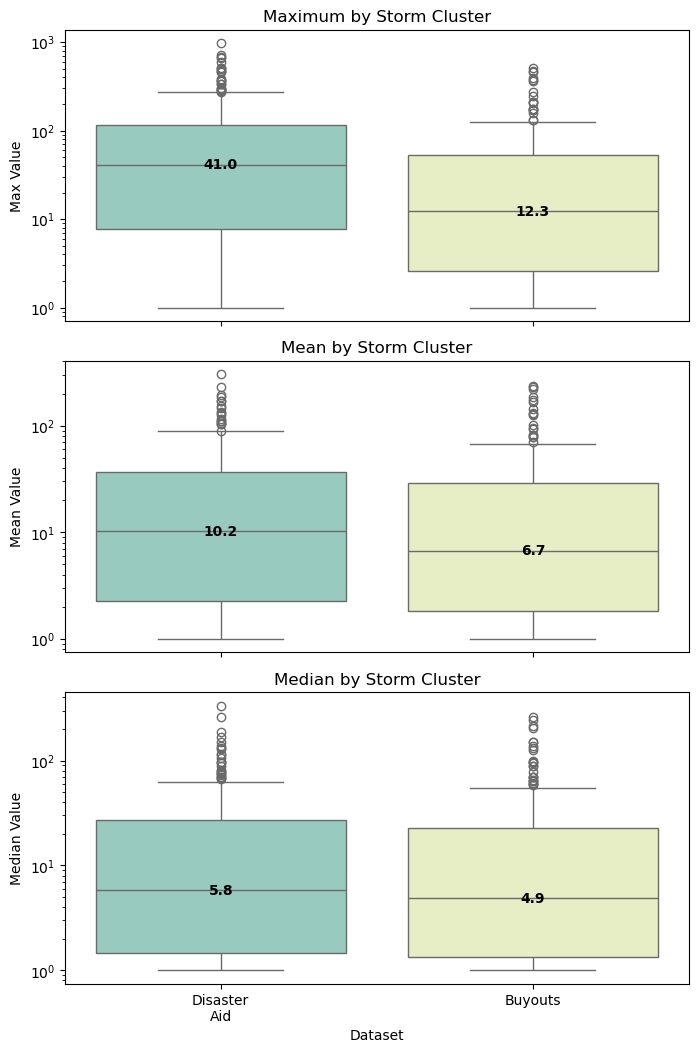

In [12]:
# Define aggregation functions and titles for subplots
aggregations = [('max', 'Max Value'), ('mean', 'Mean Value'), ('median', 'Median Value')]
titles = ['Maximum by Storm Cluster', 'Mean by Storm Cluster', 'Median by Storm Cluster']

# Set plot dimensions for vertical stacking
fig_width = 7.09  # inches
fig_height = fig_width * 1.5  # Adjust aspect ratio for vertical stacking
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(fig_width, fig_height), sharex=True)

# Define colors
colors = ["#90d2c3", "#ecf4be"]  # Aid and Buyouts respectively

for ax, (agg_func, value_name), title in zip(axes, aggregations, titles):
    # Prepare the data
    melted_data = prepare_data_disaster(buyouts, aid_expanded_data, var, agg_func, value_name, group='disasterNumber')
    
    # Plot the boxplot
    sns.boxplot(
        x='Dataset', 
        y=value_name, 
        data=melted_data, 
        ax=ax, 
        palette=colors
    )
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.set_title(title)
    ax.set_xlabel('')  # Remove x-axis label for all but the last plot
    ax.set_ylabel(value_name)

    # Annotate median values
    medians = melted_data.groupby('Dataset')[value_name].median()
    dataset_order = ['Disaster\nAid', 'Buyouts']  # Explicit order matching the plot
    for i, dataset in enumerate(dataset_order):
        median = medians[dataset]
        ax.text(i, median, f'{median:.1f}', ha='center', va='center', fontweight='bold', color='black')

# Add a shared x-axis label
axes[-1].set_xlabel('Dataset')

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [13]:
# Keep text editable in Illustrator & compress rasters
mpl.rcParams.update({
    "pdf.fonttype": 42,      # TrueType text
    "ps.fonttype": 42,
    "pdf.compression": 9,
    "path.simplify": True,
    "path.simplify_threshold": 0.3,
})

# Rasterize non-line collections on an axes (good for polygon fills, bars, boxes)
def rasterize_non_lines(ax):
    for coll in ax.collections:
        coll.set_rasterized(True)
        coll.set_zorder(0)
    for patch in ax.patches:              # bars, box rectangles, violins
        patch.set_rasterized(True)
        patch.set_zorder(0)
    for art in getattr(ax, "artists", []):  # seaborn box patches live here
        if hasattr(art, "set_rasterized"):
            art.set_rasterized(True)
            art.set_zorder(0)
    for line in ax.lines:                 # whiskers, caps, medians, hlines
        line.set_rasterized(True)
        line.set_zorder(0)

90th Percentile of cluster sizes: 137.40000000000055
50th Percentile (Median) of cluster sizes: 15.0


/tmp/ipykernel_1675/964548648.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/964548648.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box1.set_xticklabels(ax_box1.get_xticklabels(), fontsize=8)  # Replace 8 with your desired font size
/tmp/ipykernel_1675/964548648.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/964548648.py:179: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box2.set_xticklabels(ax_box2.get_xticklabels(), fontsize=8)  # Replace 8 with your de

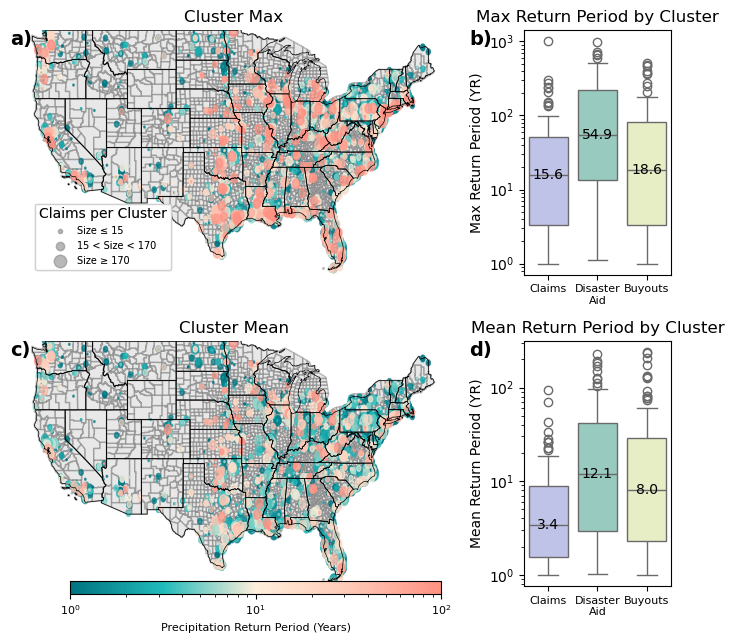

In [18]:
# Prepare the data for the first and second plot (max and mean by storm cluster)
melted_data_max = prepare_data(buyouts, aid_expanded_data, claims_clusters, var, 'max', 'Max Return Period (YR)', group=optimal_cluster)
melted_data_mean = prepare_data(buyouts, aid_expanded_data, claims_clusters, var, 'mean', 'Mean Return Period (YR)', group=optimal_cluster)

# Prepare the data for the second plot (clustered vs unclustered claims data)
claims_clusters['Cluster_Group'] = claims_clusters[optimal_cluster].apply(lambda x: 'Unclustered' if x == -1 else 'Clustered')
claims_clusters['Dataset'] = 'Claims'
filtered_data = claims_clusters[claims_clusters['Cluster_Group'].isin(['Clustered', 'Unclustered'])]

cluster_centers = claims_clusters.groupby(optimal_cluster).agg(
    median_latitude=('latitude', 'median'),
    median_longitude=('longitude', 'median'),
    cluster_size=('latitude', 'size'),  # Count rows in each cluster
    variable_max=(var, 'max'),  # Max of the variable `var` for color mapping
    variable_mean=(var, 'mean')  # Mean of the variable `var` for color mapping
).reset_index()

# Sort by variable_max value to plot higher values last
cluster_centers = cluster_centers.sort_values(by='variable_max', ascending=True)

# Calculate the 90th and 50th percentiles of the cluster_size
percentile_90 = np.percentile(cluster_centers['cluster_size'], 90)
percentile_50 = np.percentile(cluster_centers['cluster_size'], 50)

# Print the results
print(f"90th Percentile of cluster sizes: {percentile_90}")
print(f"50th Percentile (Median) of cluster sizes: {percentile_50}")

# Classify cluster sizes into the three categories
cluster_centers['radius'] = cluster_centers['cluster_size'].apply(classify_radius)

# Load the county shapefile
county_shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Set up figure dimensions
fig_width = 7.08  # inches
fig_height = fig_width*0.9 # Adjust aspect ratio for the layout

# Create a 2x2 GridSpec layout
fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(2, 2, width_ratios=[3, 1])  # Maps wider than boxplots

# Create axes for maps
ax_map1 = fig.add_subplot(gs[0, 0])  # First map (Clustered Claims)
ax_map2 = fig.add_subplot(gs[1, 0])  # Second map (Unclustered Claims)

# Create axes for boxplots
ax_box1 = fig.add_subplot(gs[0, 1])  # Boxplot for mean return period
ax_box2 = fig.add_subplot(gs[1, 1])  # Boxplot for clustered vs unclustered

# Define map extents (Contiguous US bounding box)
extent = [-125, -66.5, 24, 49]  # [min_lon, max_lon, min_lat, max_lat]

# Custom color palette for mapping
colors = ['#007380', '#21BBBB', '#FFEFDB', '#ffcab7', '#ff9183']
cmap_left = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log normalization

# Create a GeoDataFrame for cluster centers
gdf_cluster_centers = gpd.GeoDataFrame(
    cluster_centers,
    geometry=gpd.points_from_xy(cluster_centers['median_longitude'], cluster_centers['median_latitude']),
    crs="EPSG:4326"
)

# Plot the first map: Clustered Claims
gdf_counties.plot(ax=ax_map1, color='lightgray', edgecolor='gray', alpha=0.5)
patches = []
for _, row in cluster_centers.iterrows():
    center = (row['median_longitude'], row['median_latitude'])
    radius = row['radius']
    color = cmap_left(norm(row['variable_max'])) if not np.isnan(row['variable_max']) else 'gray'
    circle = Circle(center, radius, edgecolor=color, facecolor=color, alpha=0.7)
    patches.append(circle)
p = PatchCollection(patches, match_original=True)
ax_map1.add_collection(p)
gdf_states.boundary.plot(ax=ax_map1, color='black', linewidth=0.5)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax_map1)
ax_map1.set_xlim(extent[0], extent[1])
ax_map1.set_ylim(extent[2], extent[3])
ax_map1.axis('off')
ax_map1.set_title("Cluster Max", fontsize=12)

# Add subplot label "a)" in the upper left
ax_map1.text(-0.05, 1, "a)", transform=ax_map1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Plot the second map: Unclustered Claims
gdf_counties.plot(ax=ax_map2, color='lightgray', edgecolor='gray', alpha=0.5)
patches = []
for _, row in cluster_centers.iterrows():
    center = (row['median_longitude'], row['median_latitude'])
    radius = row['radius']
    color = cmap_left(norm(row['variable_mean'])) if not np.isnan(row['variable_mean']) else 'gray'
    circle = Circle(center, radius, edgecolor=color, facecolor=color, alpha=0.7)
    patches.append(circle)
p = PatchCollection(patches, match_original=True)
ax_map2.add_collection(p)
gdf_states.boundary.plot(ax=ax_map2, color='black', linewidth=0.5)

# Rasterize heavy fills on the map only (keeps boundaries/text vector)
rasterize_non_lines(ax_map2)
ax_map2.set_xlim(extent[0], extent[1])
ax_map2.set_ylim(extent[2], extent[3])
ax_map2.axis('off')
ax_map2.set_title("Cluster Mean", fontsize=12)

# Add subplot label "c)" in the upper left
ax_map2.text(-0.05, 1, "c)", transform=ax_map2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add legend for point sizes with varying sizes
legend_elements = [
    Line2D([0], [0], marker='o', color='gray', markersize=3, label='Size ≤ 15', linestyle='None', alpha=0.5),
    Line2D([0], [0], marker='o', color='gray', markersize=6, label='15 < Size < 170', linestyle='None', alpha=0.5),
    Line2D([0], [0], marker='o', color='gray', markersize=9, label='Size ≥ 170', linestyle='None', alpha=0.5),
]

legend = ax_map1.legend(handles=legend_elements, loc='lower left', title='Claims per Cluster', frameon=True, fontsize=7)
ax_map1.add_artist(legend)

# Add horizontal colorbar below the second map
cbar_ax = fig.add_axes([ax_map2.get_position().x0,  # Align with the left side of ax_map2
                        ax_map2.get_position().y0 - 0.05,  # Slightly below ax_map2
                        ax_map2.get_position().width,  # Match width of ax_map2
                        0.02])  # Height of the colorbar

# Create ScalarMappable for colorbar
sm1 = plt.cm.ScalarMappable(cmap=cmap_left, norm=norm)
cb1 = fig.colorbar(sm1, cax=cbar_ax, orientation='horizontal')
cb1.ax.tick_params(labelsize=8)  # Adjust tick size
cb1.set_label('Precipitation Return Period (Years)', fontsize=8)  # Label for colorbar

# Plot the first boxplot: Mean Return Period
sns.boxplot(
    x='Dataset',
    y='Max Return Period (YR)',
    data=melted_data_max,
    ax=ax_box1,
    palette=["#babeee", "#90d2c3", "#ecf4be"]
)
rasterize_non_lines(ax_box1)
ax_box1.set_yscale('log')
ax_box1.set_title('Max Return Period by Cluster')
ax_box1.set_ylabel('Max Return Period (YR)')
ax_box1.set_xlabel('')
# Adjust x-axis label font size for the first boxplot
ax_box1.set_xticklabels(ax_box1.get_xticklabels(), fontsize=8)  # Replace 8 with your desired font size

medians_mean = melted_data_max.groupby('Dataset')['Max Return Period (YR)'].median()
dataset_order = ['Claims', 'Disaster\nAid', 'Buyouts']
for i, dataset in enumerate(dataset_order):
    median = medians_mean.get(dataset, None)
    if median is not None:
        ax_box1.text(i, median, f'{median:.1f}', ha='center', va='center', color='black')

# Add subplot label "b)" in the upper left
ax_box1.text(-0.37, 1, "b)", transform=ax_box1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Plot the second boxplot: Clustered vs Unclustered
sns.boxplot(
    x='Dataset',
    y='Mean Return Period (YR)',
    data=melted_data_mean,
    ax=ax_box2,
    palette=["#babeee", "#90d2c3", "#ecf4be"]
)
rasterize_non_lines(ax_box2)
ax_box2.set_yscale('log')
ax_box2.set_title('Mean Return Period by Cluster')
ax_box2.set_ylabel('Mean Return Period (YR)')
ax_box2.set_xlabel('')
# Adjust x-axis label font size for the first boxplot
ax_box2.set_xticklabels(ax_box2.get_xticklabels(), fontsize=8)  # Replace 8 with your desired font size

medians_mean = melted_data_mean.groupby('Dataset')['Mean Return Period (YR)'].median()
dataset_order = ['Claims', 'Disaster\nAid', 'Buyouts']
for i, dataset in enumerate(dataset_order):
    median = medians_mean.get(dataset, None)
    if median is not None:
        ax_box2.text(i, median, f'{median:.1f}', ha='center', va='center', color='black')

# Add subplot label "d)" in the upper left
ax_box2.text(-0.37, 1, "d)", transform=ax_box2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Adjust layout and show the plot
plt.tight_layout()

if save:
    plt.savefig('Plots/'+folder+'Fig_7_Cluster'+name+'.pdf',
        format='pdf', dpi=500, bbox_inches='tight')

plt.show()

# Using Storm Clustering

90th Percentile of cluster sizes: 137.40000000000055
50th Percentile (Median) of cluster sizes: 15.0


/tmp/ipykernel_1675/3133408395.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/3133408395.py:150: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box1.set_xticklabels(ax_box1.get_xticklabels(), fontsize=8)  # Replace 8 with your desired font size
/tmp/ipykernel_1675/3133408395.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/3133408395.py:176: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box2.set_xticklabels(ax_box2.get_xticklabels(), fontsize=8)  # Replace 8 with you

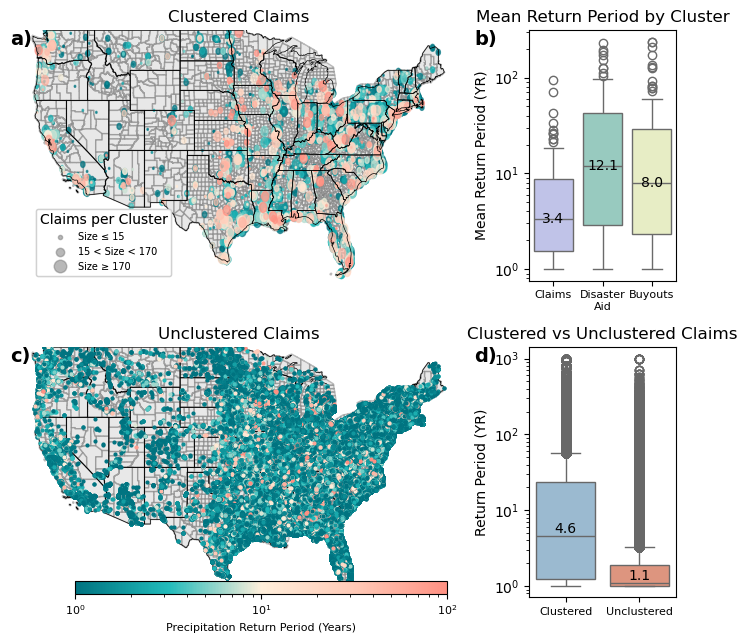

In [15]:
# Prepare the data for the first plot (mean by storm cluster)
melted_data_mean = prepare_data(buyouts, aid_expanded_data, claims_clusters, var, 'mean', 'Mean Return Period (YR)', group=optimal_cluster)

# Prepare the data for the second plot (clustered vs unclustered claims data)
claims_clusters['Cluster_Group'] = claims_clusters[optimal_cluster].apply(lambda x: 'Unclustered' if x == -1 else 'Clustered')
claims_clusters['Dataset'] = 'Claims'
filtered_data = claims_clusters[claims_clusters['Cluster_Group'].isin(['Clustered', 'Unclustered'])]

cluster_centers = claims_clusters.groupby(optimal_cluster).agg(
    median_latitude=('latitude', 'median'),
    median_longitude=('longitude', 'median'),
    cluster_size=('latitude', 'size'),  # Count rows in each cluster
    variable=(var, 'mean')  # Median of the variable `var` for color mapping
).reset_index()

# Sort by variable value to plot higher values last
cluster_centers = cluster_centers.sort_values(by='variable', ascending=True)

# Calculate the 90th and 50th percentiles of the cluster_size
percentile_90 = np.percentile(cluster_centers['cluster_size'], 90)
percentile_50 = np.percentile(cluster_centers['cluster_size'], 50)

# Print the results
print(f"90th Percentile of cluster sizes: {percentile_90}")
print(f"50th Percentile (Median) of cluster sizes: {percentile_50}")

# Classify cluster sizes into the three categories
cluster_centers['radius'] = cluster_centers['cluster_size'].apply(classify_radius)

# Load the county shapefile
county_shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Set up figure dimensions
fig_width = 7.08  # inches
fig_height = fig_width*0.9 # Adjust aspect ratio for the layout

# Create a 2x2 GridSpec layout
fig = plt.figure(figsize=(fig_width, fig_height))
gs = GridSpec(2, 2, width_ratios=[3, 1])  # Maps wider than boxplots

# Create axes for maps
ax_map1 = fig.add_subplot(gs[0, 0])  # First map (Clustered Claims)
ax_map2 = fig.add_subplot(gs[1, 0])  # Second map (Unclustered Claims)

# Create axes for boxplots
ax_box1 = fig.add_subplot(gs[0, 1])  # Boxplot for mean return period
ax_box2 = fig.add_subplot(gs[1, 1])  # Boxplot for clustered vs unclustered

# Define map extents (Contiguous US bounding box)
extent = [-125, -66.5, 24, 49]  # [min_lon, max_lon, min_lat, max_lat]

# Custom color palette for mapping
colors = ['#007380', '#21BBBB', '#FFEFDB', '#ffcab7', '#ff9183']
cmap_left = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log normalization

# Map the variable `var` to colors
cluster_centers['color'] = cluster_centers['variable'].apply(lambda x: cmap_left(norm(x)) if not np.isnan(x) else 'gray')

# Create a GeoDataFrame for cluster centers
gdf_cluster_centers = gpd.GeoDataFrame(
    cluster_centers,
    geometry=gpd.points_from_xy(cluster_centers['median_longitude'], cluster_centers['median_latitude']),
    crs="EPSG:4326"
)

# Plot the first map: Clustered Claims
gdf_counties.plot(ax=ax_map1, color='lightgray', edgecolor='gray', alpha=0.5)
gdf_states.boundary.plot(ax=ax_map1, color='black', linewidth=0.5)
patches = []
for _, row in cluster_centers.iterrows():
    center = (row['median_longitude'], row['median_latitude'])
    radius = row['radius']
    color = cmap_left(norm(row['variable'])) if not np.isnan(row['variable']) else 'gray'
    circle = Circle(center, radius, edgecolor=color, facecolor=color, alpha=0.7)
    patches.append(circle)
p = PatchCollection(patches, match_original=True)
ax_map1.add_collection(p)
ax_map1.set_xlim(extent[0], extent[1])
ax_map1.set_ylim(extent[2], extent[3])
ax_map1.axis('off')
ax_map1.set_title("Clustered Claims", fontsize=12)

# Add subplot label "a)" in the upper left
ax_map1.text(-0.05, 1, "a)", transform=ax_map1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Plot the second map: Unclustered Claims
gdf_counties.plot(ax=ax_map2, color='lightgray', edgecolor='gray', alpha=0.5)
gdf_states.boundary.plot(ax=ax_map2, color='black', linewidth=0.5)
unclustered_points = claims_clusters[claims_clusters['Cluster_Group'] == "Unclustered"]
gdf_points = gpd.GeoDataFrame(
    unclustered_points,
    geometry=gpd.points_from_xy(unclustered_points['longitude'], unclustered_points['latitude']),
    crs="EPSG:4326"
)
for _, row in gdf_points.iterrows():
    color = cmap_left(norm(row[var])) if not np.isnan(row[var]) else 'gray'
    ax_map2.plot(
        row.geometry.x, row.geometry.y,
        marker='o', color=color, markersize=2
    )
ax_map2.set_xlim(extent[0], extent[1])
ax_map2.set_ylim(extent[2], extent[3])
ax_map2.axis('off')
ax_map2.set_title("Unclustered Claims", fontsize=12)

# Add subplot label "c)" in the upper left
ax_map2.text(-0.05, 1, "c)", transform=ax_map2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add legend for point sizes with varying sizes
legend_elements = [
    Line2D([0], [0], marker='o', color='gray', markersize=3, label='Size ≤ 15', linestyle='None', alpha=0.5),
    Line2D([0], [0], marker='o', color='gray', markersize=6, label='15 < Size < 170', linestyle='None', alpha=0.5),
    Line2D([0], [0], marker='o', color='gray', markersize=9, label='Size ≥ 170', linestyle='None', alpha=0.5),
]

legend = ax_map1.legend(handles=legend_elements, loc='lower left', title='Claims per Cluster', frameon=True, fontsize=7)
ax_map1.add_artist(legend)

# Add horizontal colorbar below the second map
cbar_ax = fig.add_axes([ax_map2.get_position().x0,  # Align with the left side of ax_map2
                        ax_map2.get_position().y0 - 0.05,  # Slightly below ax_map2
                        ax_map2.get_position().width,  # Match width of ax_map2
                        0.02])  # Height of the colorbar

# Create ScalarMappable for colorbar
sm1 = plt.cm.ScalarMappable(cmap=cmap_left, norm=norm)
cb1 = fig.colorbar(sm1, cax=cbar_ax, orientation='horizontal')
cb1.ax.tick_params(labelsize=8)  # Adjust tick size
cb1.set_label('Precipitation Return Period (Years)', fontsize=8)  # Label for colorbar

# Plot the first boxplot: Mean Return Period
sns.boxplot(
    x='Dataset',
    y='Mean Return Period (YR)',
    data=melted_data_mean,
    ax=ax_box1,
    palette=["#babeee", "#90d2c3", "#ecf4be"]
)
ax_box1.set_yscale('log')
ax_box1.set_title('Mean Return Period by Cluster')
ax_box1.set_ylabel('Mean Return Period (YR)')
ax_box1.set_xlabel('')
# Adjust x-axis label font size for the first boxplot
ax_box1.set_xticklabels(ax_box1.get_xticklabels(), fontsize=8)  # Replace 8 with your desired font size

# Add subplot label "b)" in the upper left
ax_box1.text(-0.37, 1, "b)", transform=ax_box1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

medians_mean = melted_data_mean.groupby('Dataset')['Mean Return Period (YR)'].median()
dataset_order = ['Claims', 'Disaster\nAid', 'Buyouts']
for i, dataset in enumerate(dataset_order):
    median = medians_mean.get(dataset, None)
    if median is not None:
        ax_box1.text(i, median, f'{median:.1f}', ha='center', va='center', color='black')

# Plot the second boxplot: Clustered vs Unclustered
sns.boxplot(
    x='Cluster_Group',
    y=var,
    data=filtered_data,
    order=['Clustered', 'Unclustered'],
    palette=["#92BCD9", "#ED8D6F"],
    ax=ax_box2
)
ax_box2.set_yscale('log')
ax_box2.set_title('Clustered vs Unclustered Claims')
ax_box2.set_ylabel('Return Period (YR)')
ax_box2.set_xlabel('')
# Adjust x-axis label font size for the second boxplot
ax_box2.set_xticklabels(ax_box2.get_xticklabels(), fontsize=8)  # Replace 8 with your desired font size

medians_clustered = filtered_data.groupby('Cluster_Group')[var].median()
for i, group in enumerate(['Clustered', 'Unclustered']):
    median = medians_clustered.get(group, None)
    if median is not None:
        ax_box2.text(i, median, f'{median:.1f}', ha='center', va='bottom', color='black')

# Add subplot label "d)" in the upper left
ax_box2.text(-0.37, 1, "d)", transform=ax_box2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Adjust layout and show the plot
plt.tight_layout()

if save:
    filepath = 'Plots/'+folder+'Fig_7_Cluster'+name+'.png'
    #plt.savefig(filepath, dpi=500, bbox_inches='tight')

plt.show()

/tmp/ipykernel_1675/1820898599.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/1820898599.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/1820898599.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


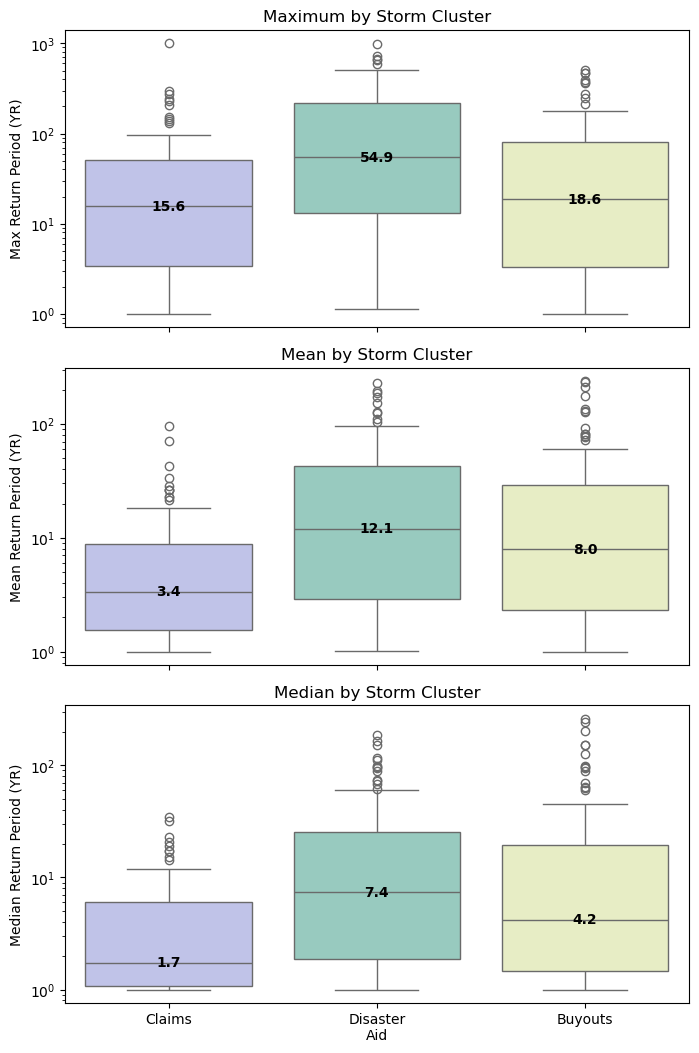

In [16]:
# Define aggregation functions and titles for subplots
aggregations = [('max', 'Max Return Period (YR)'), ('mean', 'Mean Return Period (YR)'), ('median', 'Median Return Period (YR)')]
titles = ['Maximum by Storm Cluster', 'Mean by Storm Cluster', 'Median by Storm Cluster']

# Set plot dimensions for vertical stacking
fig_width = 7.09  # inches
fig_height = fig_width * 1.5  # Adjust aspect ratio for vertical stacking
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(fig_width, fig_height), sharex=True)

# Define colors
colors = ["#babeee", "#90d2c3", "#ecf4be"]  # Claims, Aid, and Buyouts respectively

for ax, (agg_func, value_name), title in zip(axes, aggregations, titles):
    # Prepare the data
    melted_data = prepare_data(buyouts, aid_expanded_data, claims_clusters, var, agg_func, value_name, group=optimal_cluster)
    
    # Plot the boxplot
    sns.boxplot(
        x='Dataset', 
        y=value_name, 
        data=melted_data, 
        ax=ax, 
        palette=colors
    )
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.set_title(title)
    ax.set_xlabel('')  # Remove x-axis label for all but the last plot
    ax.set_ylabel(value_name)

    # Annotate median values
    medians = melted_data.groupby('Dataset')[value_name].median()
    dataset_order = ['Claims', 'Disaster\nAid', 'Buyouts']  # Explicit order matching the plot
    for i, dataset in enumerate(dataset_order):
        median = medians[dataset]
        ax.text(i, median, f'{median:.1f}', ha='center', va='center', fontweight='bold', color='black')

# Add a shared x-axis label
#axes[-1].set_xlabel('Dataset')

# Adjust layout for readability
plt.tight_layout()
plt.show()

/tmp/ipykernel_1675/2309823349.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1675/2309823349.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


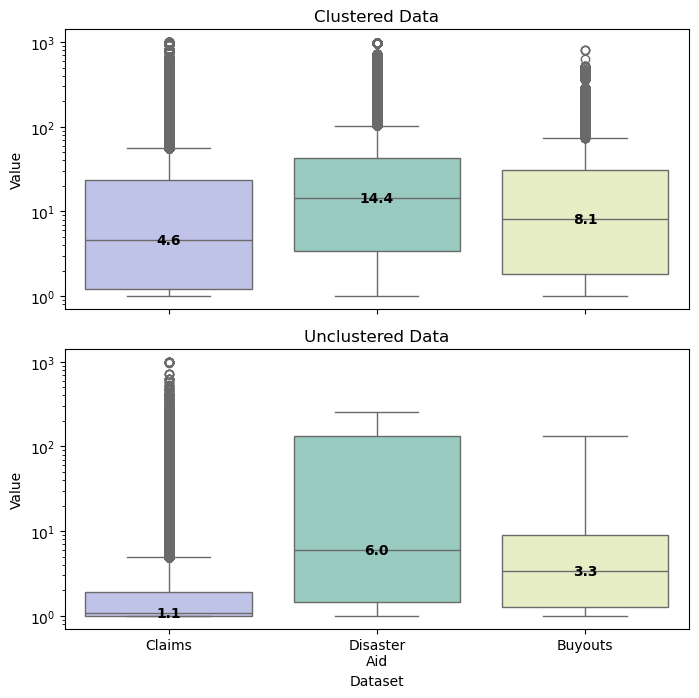

In [17]:
# Assign a name attribute to the datasets for identification
claims_clusters.name = 'Claims'
aid_expanded_data.name = 'Disaster\nAid'
buyouts.name = 'Buyouts'

# Prepare the data
claims_clusters, aid_expanded_data, buyouts = split_and_prepare_data(claims_clusters, aid_expanded_data, buyouts, var, optimal_cluster)

# Combine all data into a single DataFrame
combined_data = pd.concat([
    claims_clusters[[var, 'Dataset', 'Cluster_Group']],
    aid_expanded_data[[var, 'Dataset', 'Cluster_Group']],
    buyouts[[var, 'Dataset', 'Cluster_Group']]
])

# Define colors for the datasets
colors = ["#babeee", "#90d2c3", "#ecf4be"]  # Claims, Aid, and Buyouts respectively

# Set plot dimensions for two vertically stacked subplots
fig_width = 7.09  # inches
fig_height = fig_width # Adjust aspect ratio for vertical stacking
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fig_width, fig_height), sharex=True, sharey=True)

# Loop through the two segments and plot
for ax, segment_name in zip(axes, ['Clustered', 'Unclustered']):
    # Filter the data for the current segment
    segment_data = combined_data[combined_data['Cluster_Group'] == segment_name]
    
    # Create the boxplot
    sns.boxplot(
        x='Dataset', 
        y=var, 
        data=segment_data, 
        ax=ax, 
        palette=colors
    )
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.set_title(f'{segment_name} Data')
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('Value')  # Y-axis label for the variable

    # Annotate median values for each dataset
    medians = segment_data.groupby('Dataset')[var].median()
    for i, dataset in enumerate(['Claims', 'Disaster\nAid', 'Buyouts']):
        median = medians.get(dataset, None)
        if median is not None:
            ax.text(i, median, f'{median:.1f}', ha='center', va='center', fontweight='bold', color='black')

# Add a shared x-axis label for the bottom plot
axes[-1].set_xlabel('Dataset')

# Adjust layout for readability
plt.tight_layout()
plt.show()